In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import urllib3
import importlib
import charts
import calculations
import patterns
import data
import config  # Import configuration

# Suppress SSL warnings when verification is disabled
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)




In [ ]:
# Use configuration from config.py
# You can override these if needed:
SYMBOL = config.SYMBOL
INTERVAL = config.INTERVAL
BASE_URL = config.BASE_URL

# Or use config values directly:
# Fetch data using config values
# klines_data = data.fetch_klines(config.SYMBOL, config.INTERVAL, limit=config.DEFAULT_LIMIT)
end_time = datetime.now()
start_time = end_time - timedelta(days=200)

klines_data = data.fetch_historical_klines(
    symbol=SYMBOL,
    interval=INTERVAL,
    start_time=start_time,
    end_time=end_time,
    rate_limit_delay=0.05
)


Fetching historical data: 10 estimated candles in 1 chunk(s)
SSL certificate verification failed. Retrying without verification...
Note: For production, install certificates properly using: pip install --upgrade certifi
Successfully fetched 10 unique candles


In [3]:
# Convert API response to DataFrame
# Binance klines response format:
# [Open time, Open, High, Low, Close, Volume, Close time, 
#  Quote volume, Trades, Taker buy base volume, Taker buy quote volume, Ignore]

column_names = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_volume',
    'trades',
    'taker_buy_base_volume',
    'taker_buy_quote_volume',
    'ignore'
]

df = pd.DataFrame(klines_data, columns=column_names)
print("DataFrame created successfully!")
print(f"Shape: {df.shape}")



DataFrame created successfully!
Shape: (10, 12)


In [4]:
# Data cleaning and type conversion
# Convert timestamps from milliseconds to datetime
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

# Convert OHLCV columns to float
ohlcv_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_volume']
for col in ohlcv_columns:
    df[col] = df[col].astype(float)

# Convert integer columns
df['trades'] = df['trades'].astype(int)
df['taker_buy_base_volume'] = df['taker_buy_base_volume'].astype(float)
df['taker_buy_quote_volume'] = df['taker_buy_quote_volume'].astype(float)

# Set open_time as index
df.set_index('open_time', inplace=True)

# Drop unnecessary columns
df.drop(['close_time', 'ignore'], axis=1, inplace=True)


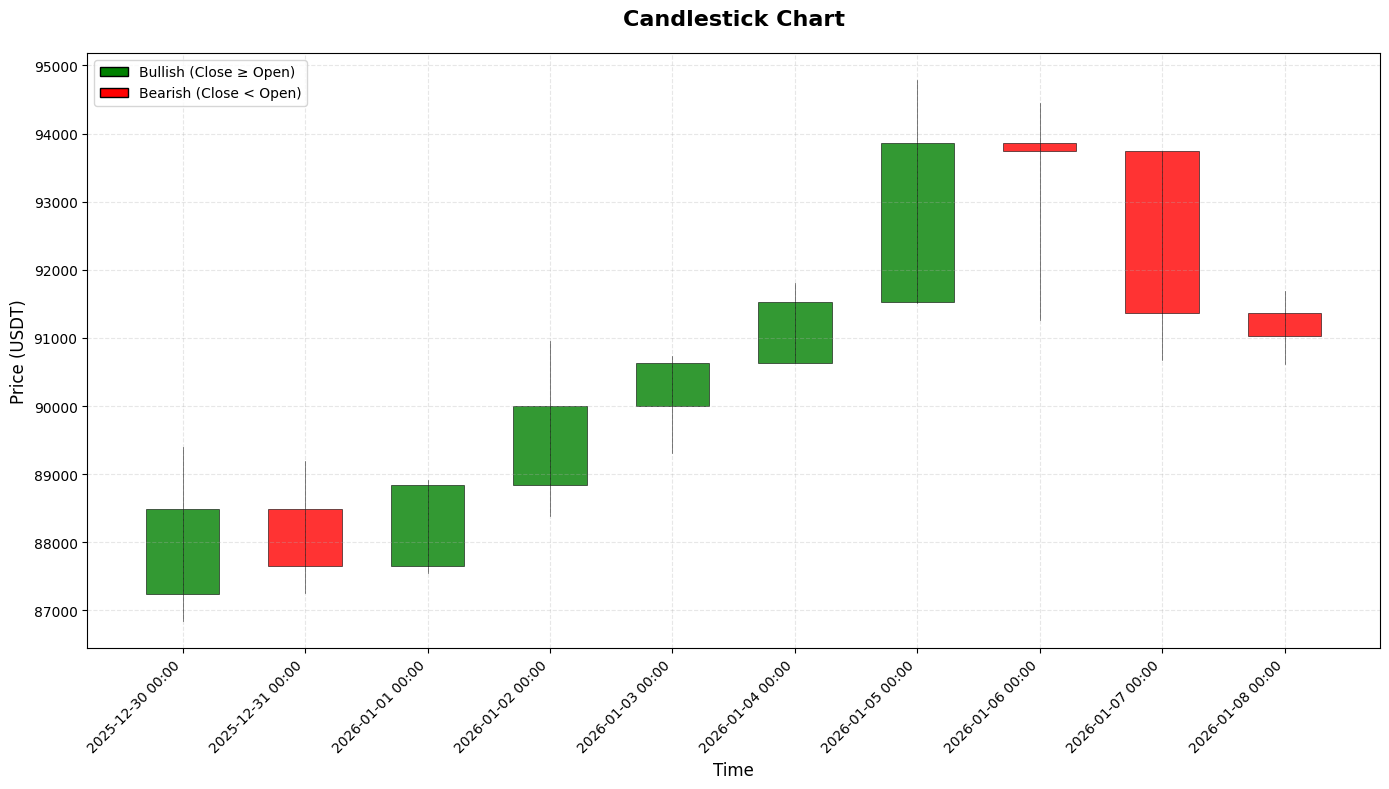


Chart Statistics:
Period: 2025-12-30 00:00:00 to 2026-01-08 00:00:00
Total Candles: 10
Price Range: $86,845.66 - $94,789.08
Current Price: $91,023.99


In [5]:
# Plot OHLC Candlestick Chart

# Plot the candlestick chart
charts.plot_candlestick(df)



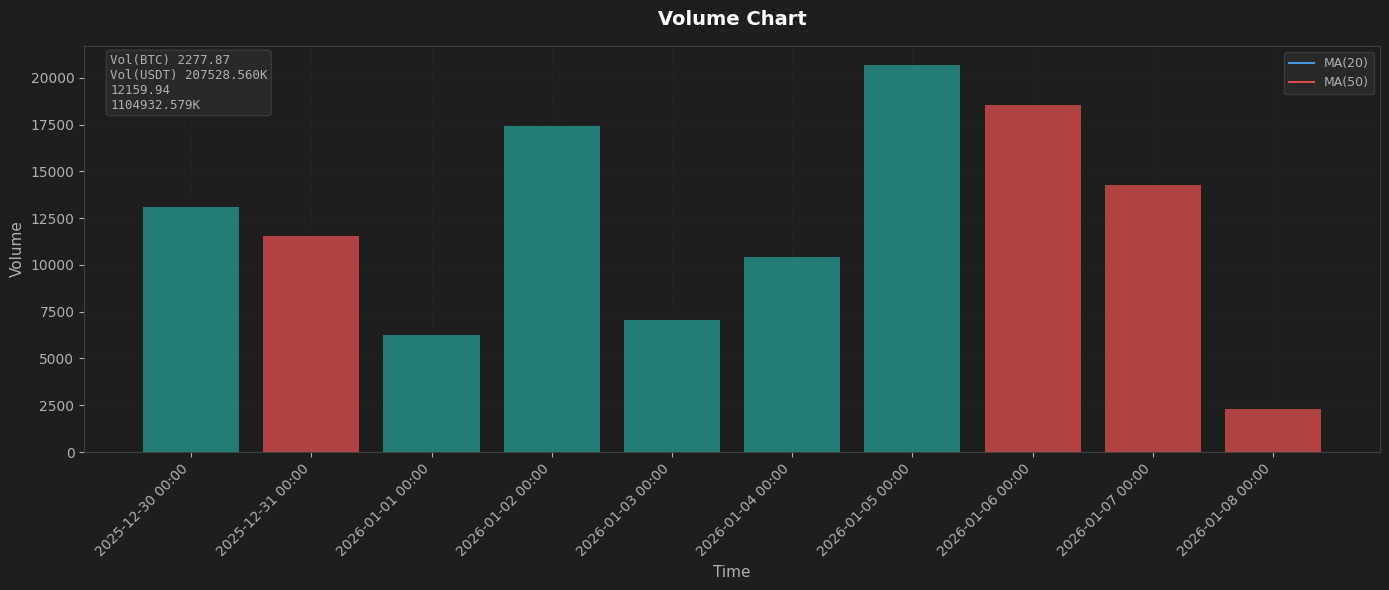


Volume Statistics:
Current Volume (BTC): 2277.8704
Current Volume (USDT): 207,528,559.63
Average Volume (BTC, last 20): 12159.9447
Average Volume (USDT, last 20): 1,104,932,578.85


In [6]:
# Plot the volume chart with moving average
charts.plot_volume_chart(df, num_candles=200)

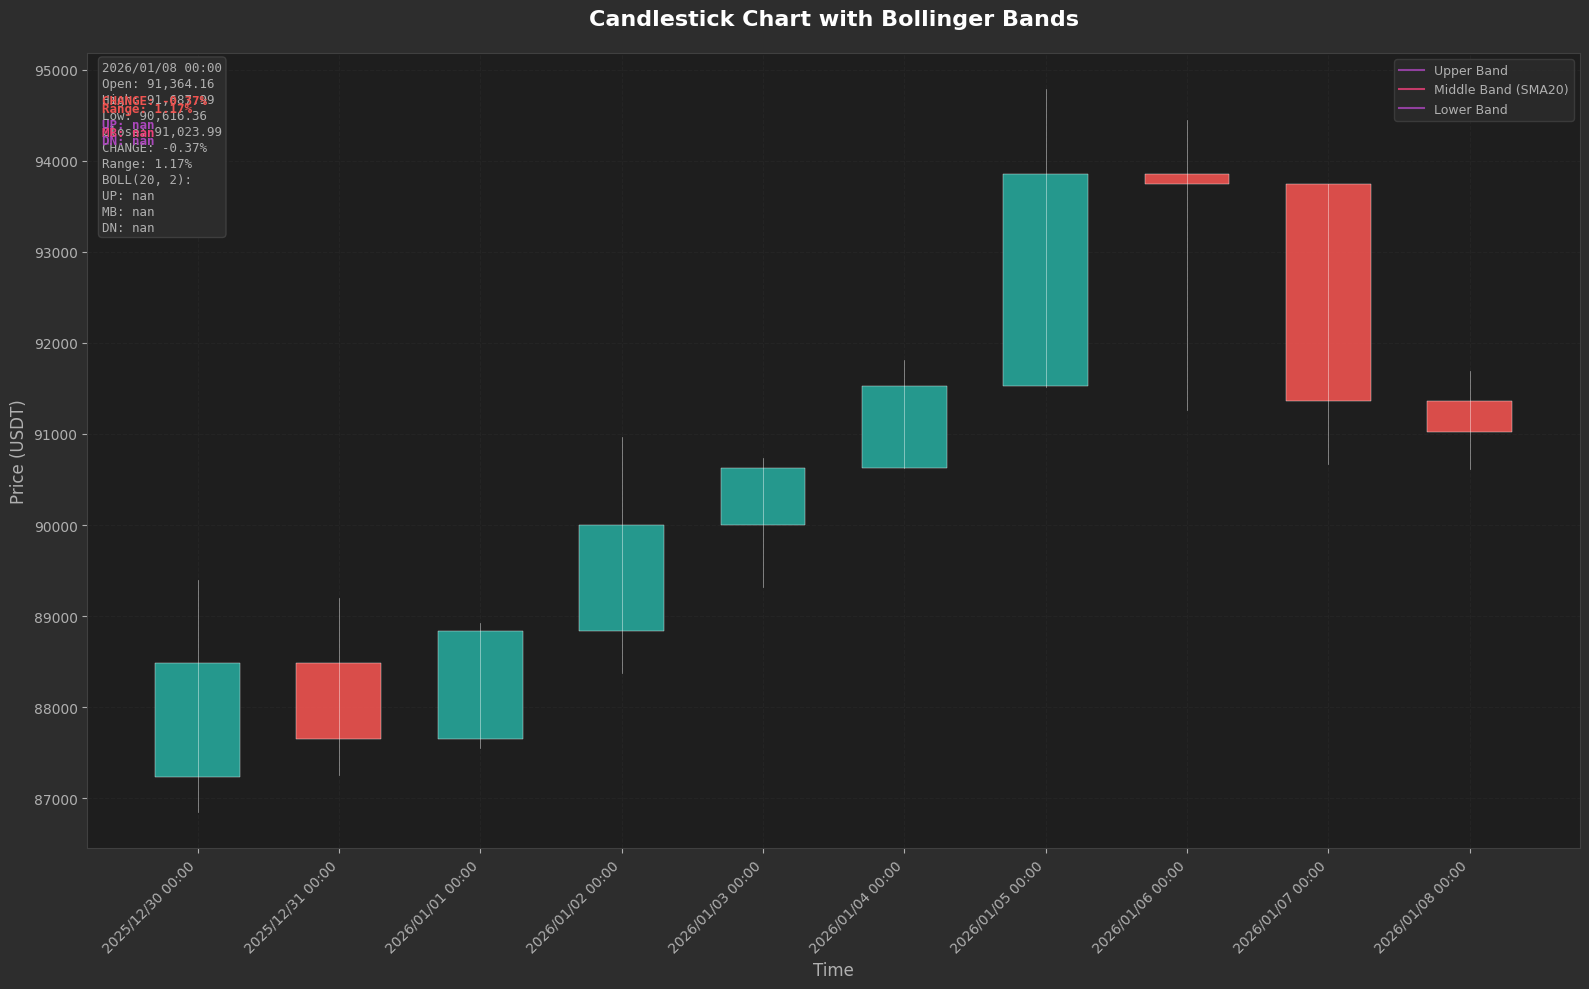


Bollinger Bands Summary:
Period: 20, Standard Deviations: 2
Current Price: $91,023.99
Upper Band: $nan
Middle Band (SMA20): $nan
Lower Band: $nan
Band Width: $nan


In [7]:
# Plot the candlestick chart with Bollinger Bands
charts.plot_candlestick_with_bollinger(df, num_candles=200)

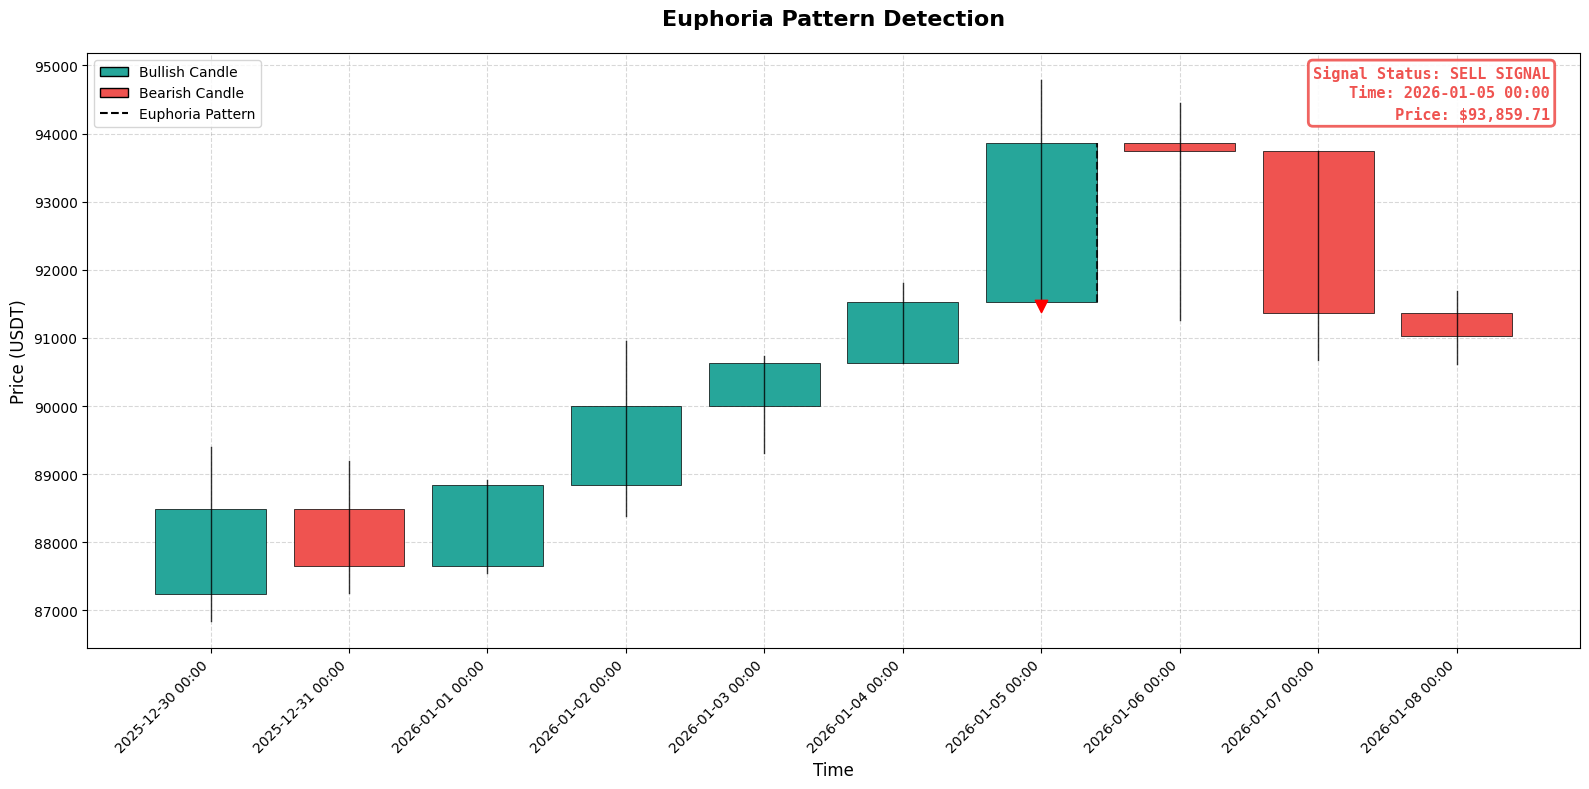


Euphoria Pattern Detection Summary:
Total Candles Analyzed: 10
Bullish Euphoria Patterns (Bearish Signal): 0
Bearish Euphoria Patterns (Bullish Signal): 1

Current Signal Status: SELL SIGNAL
Last Signal Time: 2026-01-05 00:00:00
Last Signal Price: $93,859.71

Bearish Euphoria (Bullish Signal) detected at:
  - 2026-01-05 00:00:00: Price = $93,859.71


In [8]:
# Detect and plot Euphoria patterns
charts.plot_candlestick_with_euphoria(df, num_candles=200)

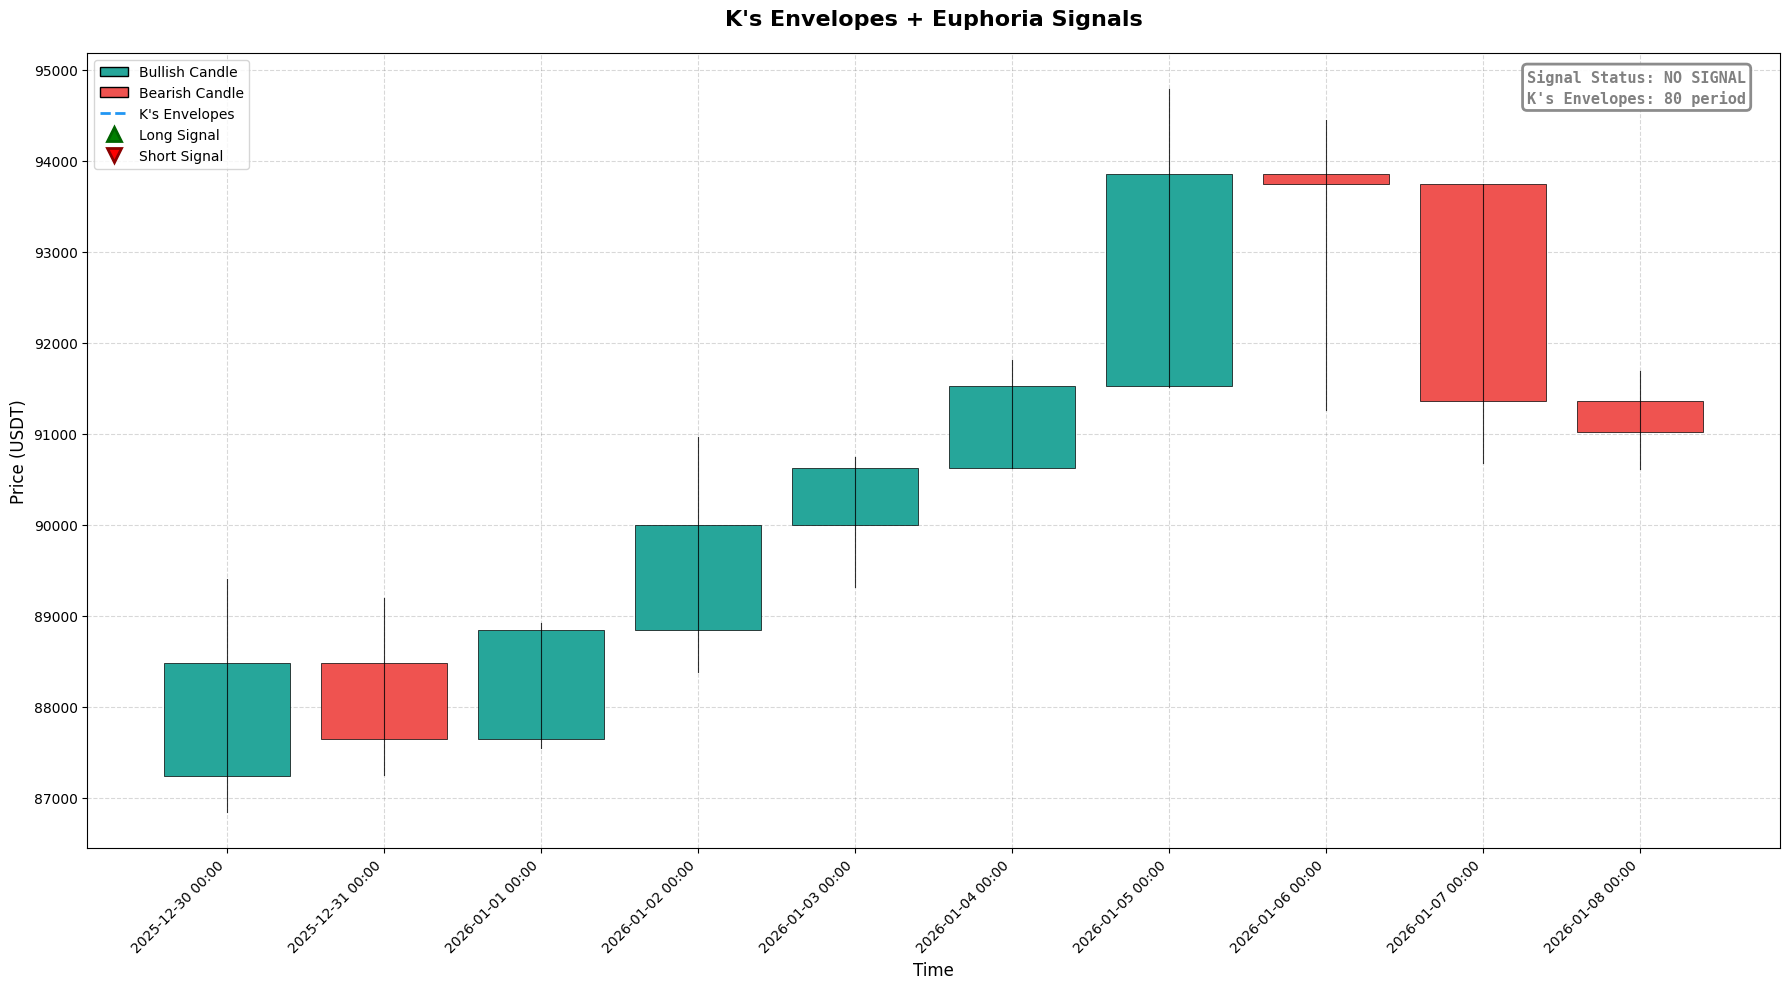


K's Envelopes + Euphoria Pattern Signal Summary:
Total Candles Analyzed: 10
K's Envelopes Period: 80
Long Signals (Buy): 0
Short Signals (Sell): 0

Current Signal Status: NO SIGNAL


In [9]:
# Plot K's Envelopes with Euphoria signals
charts.plot_k_envelopes_euphoria_signals(df, num_candles=200, lookback=80)

## Volume Confirmation for Euphoria Signals

**Approach:**
1. **Volume Trend Analysis**: Calculate volume moving averages to identify decreasing volume during euphoria pattern formation
2. **Volume Spike Detection**: Identify volume spikes on the reversal candle (signal candle)
3. **Volume Confirmation Rules**:
   - For BUY signals (bullish euphoria): Volume should be decreasing during the pattern formation, indicating exhaustion
   - For SELL signals (bearish euphoria): Volume should be decreasing during the pattern formation, indicating exhaustion
   - Volume spike on the signal candle increases conviction
4. **Signal Classification**: 
   - **Confirmed Signal**: Euphoria pattern + price in K's envelopes + volume confirmation
   - **Unconfirmed Signal**: Euphoria pattern + price in K's envelopes but no volume confirmation
5. **Visualization**: 
   - Plot volume bars with moving averages
   - Mark confirmed signals with stronger markers/colors
   - Show volume confirmation status in signal annotations



/Users/bennetto/candles/charts.py:1098: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


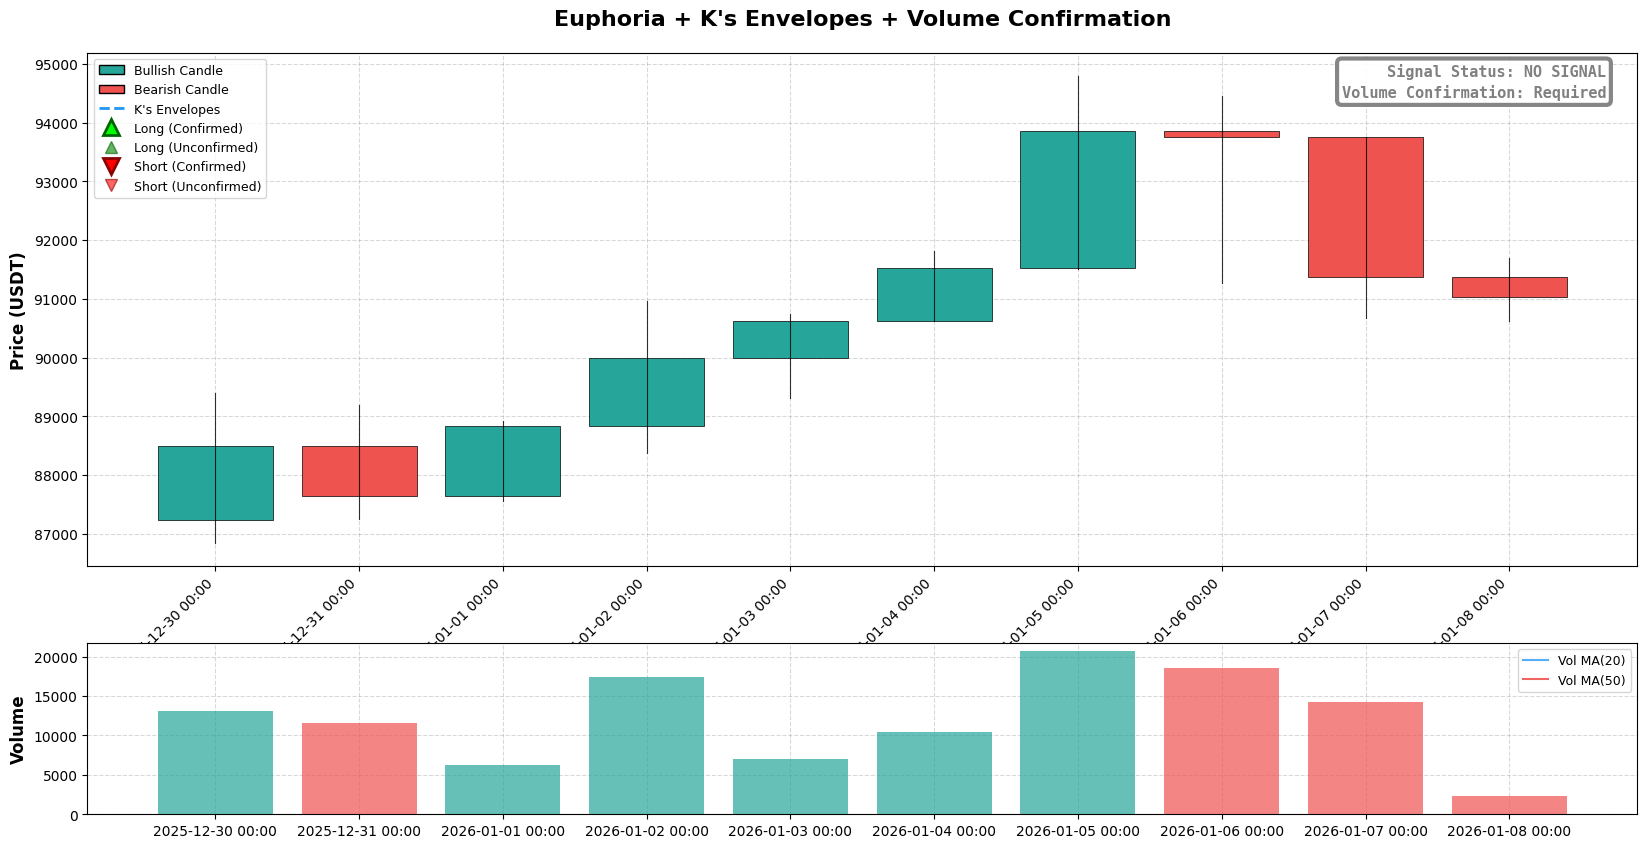


Euphoria + K's Envelopes + Volume Confirmation Summary:
Total Candles Analyzed: 10
K's Envelopes Period: 80

Long Signals:
  Total: 0
  Volume Confirmed: 0 (0%)

Short Signals:
  Total: 0
  Volume Confirmed: 0 (0%)

Current Signal Status: NO SIGNAL


In [10]:
# Plot with volume confirmation
charts.plot_euphoria_with_volume_confirmation(df, num_candles=200, lookback=80)

## RSI Confluence for Euphoria Signals

**Approach:**
1. **RSI Calculation**: Calculate RSI (default 14-period) to measure momentum
2. **Overbought/Oversold Detection**: 
   - Overbought: RSI > 70 (suggests price overextension)
   - Oversold: RSI < 30 (suggests price overselling)
3. **Divergence Detection**:
   - **Bearish Divergence**: Price makes higher highs while RSI makes lower highs (momentum weakening)
   - **Bullish Divergence**: Price makes lower lows while RSI makes higher lows (momentum strengthening)
4. **RSI Confirmation Rules**:
   - For BUY signals (bullish euphoria): RSI should be oversold (<30) or showing bullish divergence
   - For SELL signals (bearish euphoria): RSI should be overbought (>70) or showing bearish divergence
5. **Multi-Confluence System**:
   - **High Conviction**: Euphoria + K's Envelopes + Volume + RSI confirmation
   - **Medium Conviction**: Euphoria + K's Envelopes + Volume (no RSI)
   - **Low Conviction**: Euphoria + K's Envelopes (no volume, no RSI)
6. **Visualization**:
   - RSI subplot showing overbought/oversold zones
   - Divergence annotations on price chart
   - Color-coded signal markers based on confluence level



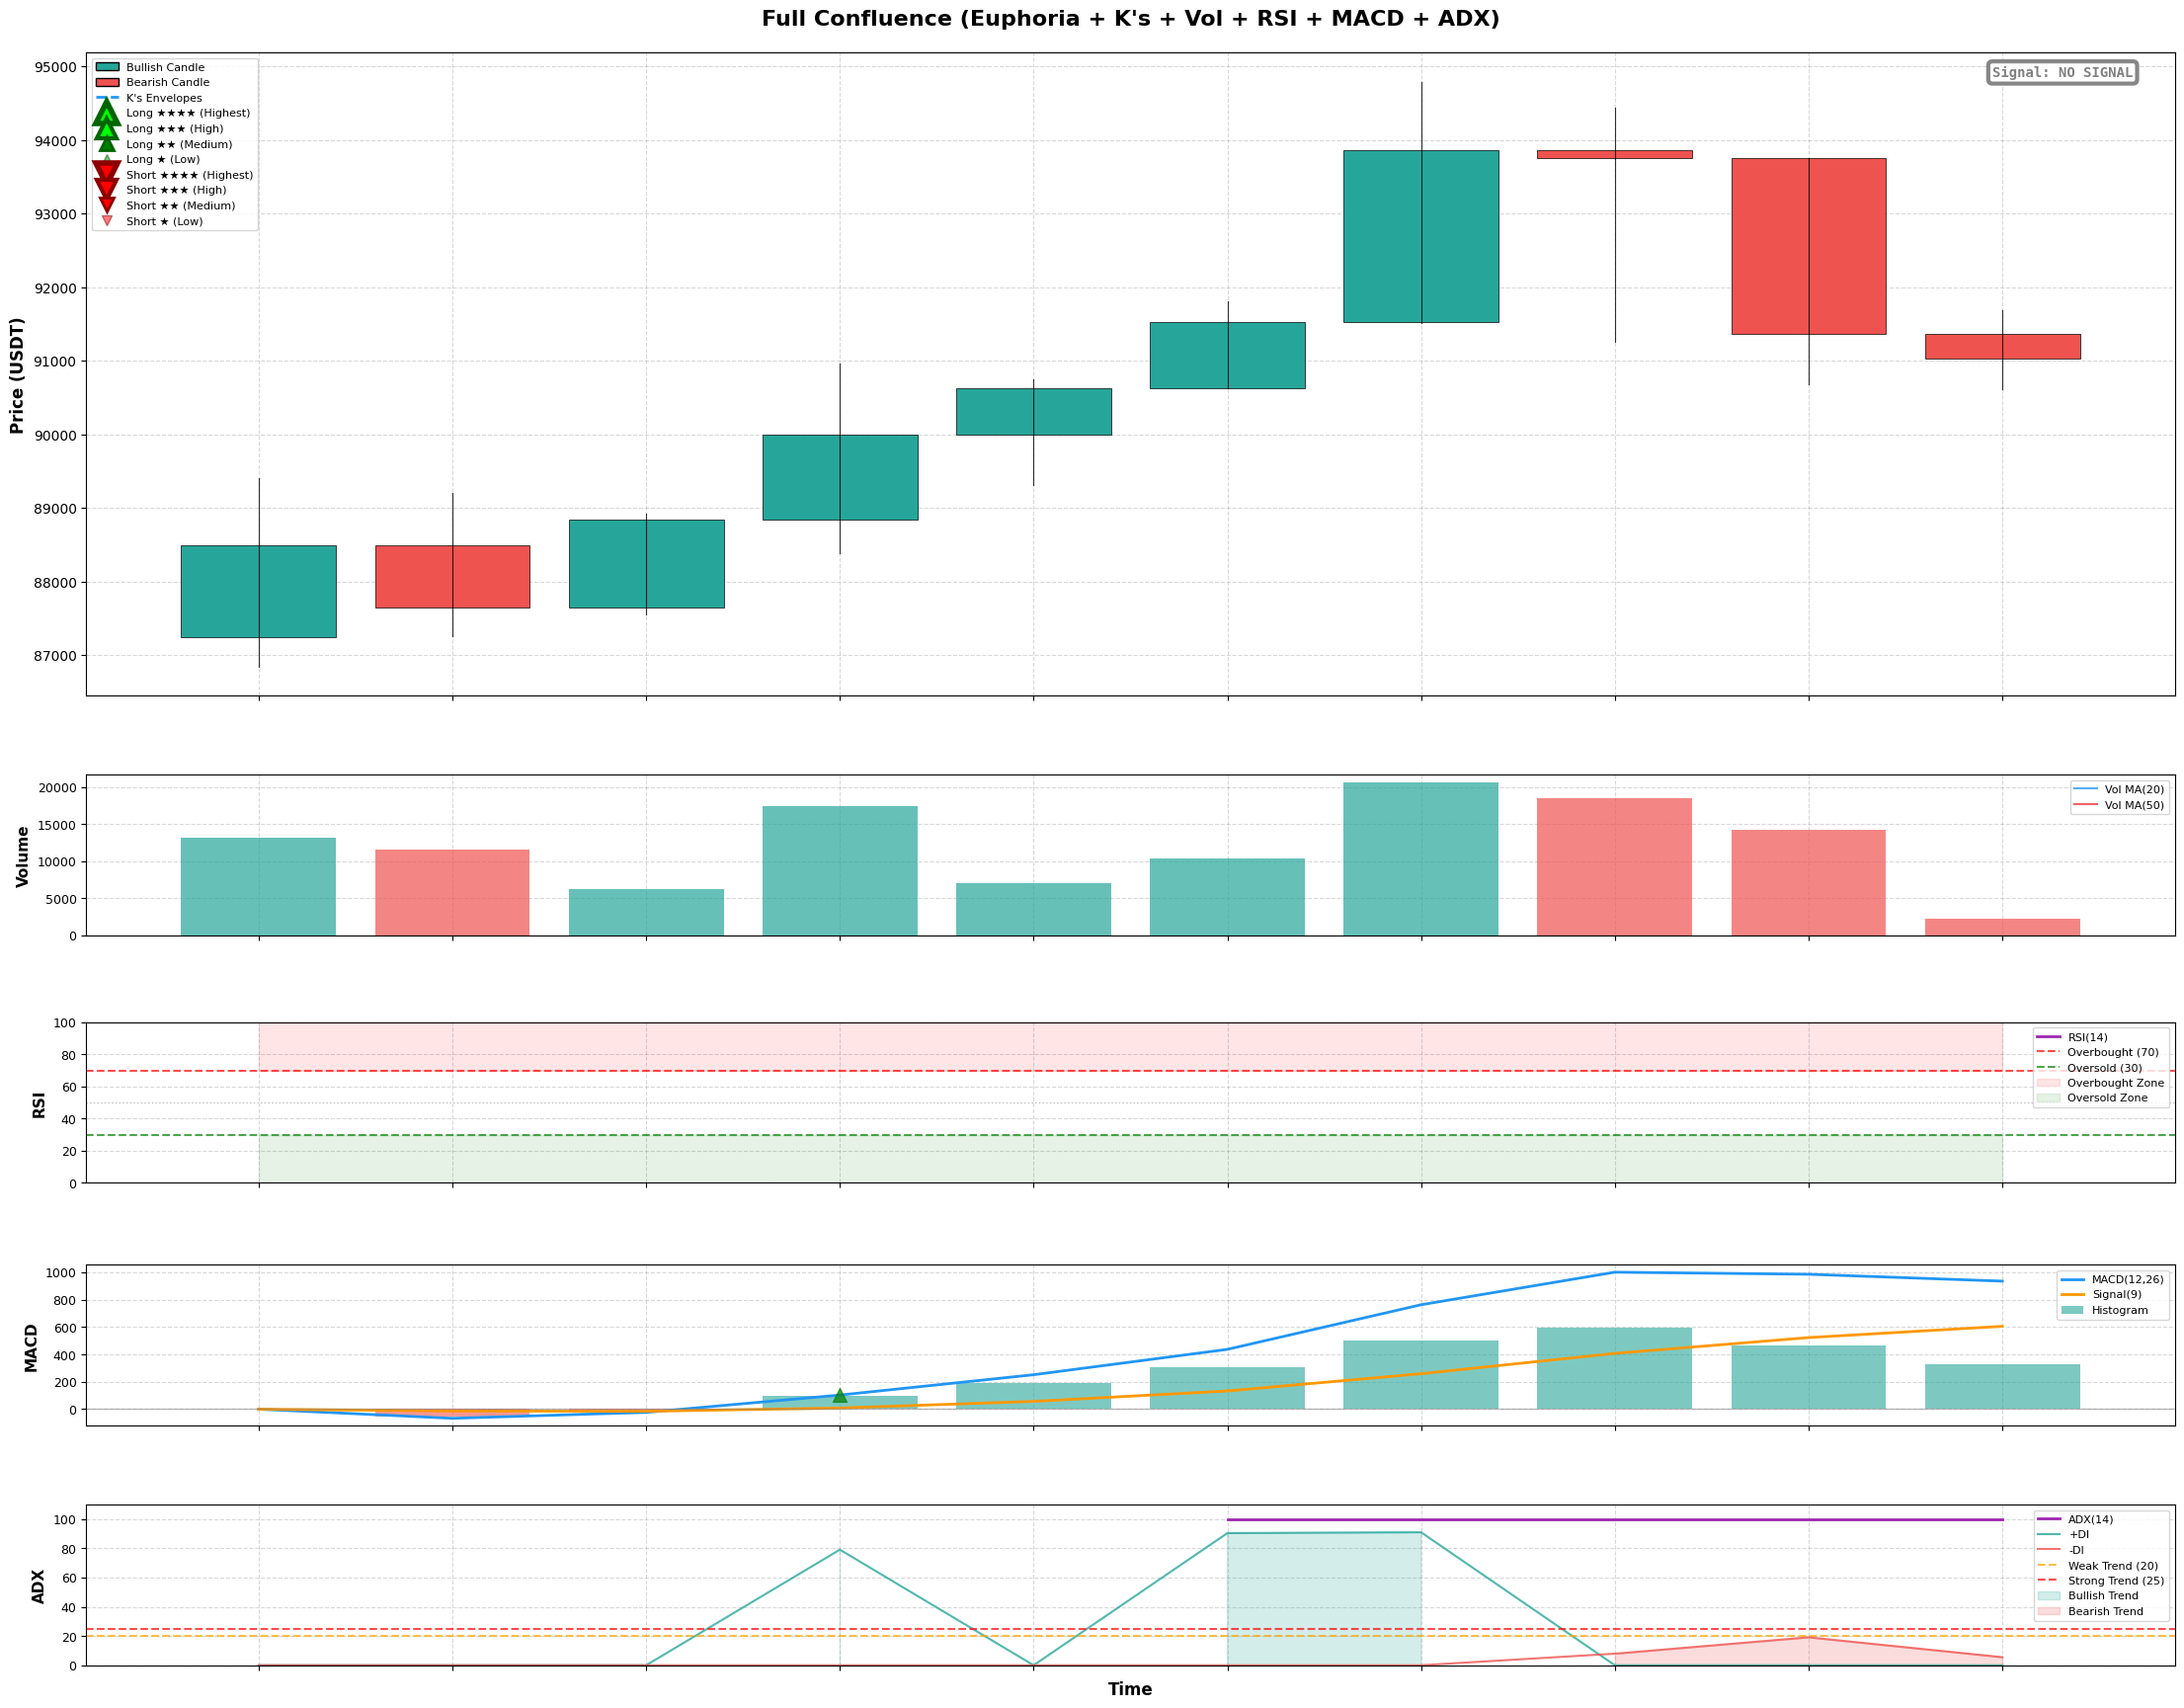


FULL CONFLUENCE SIGNAL SUMMARY
Total Candles Analyzed: 10
K's Envelopes Period: 80 | RSI Period: 14 | MACD: 12,26,9

LONG SIGNALS:
  ★★★★ Highest Conviction (All 4): 0
  ★★★ High Conviction (3 of 4): 0
  ★★ Medium Conviction (2 of 4): 0
  ★ Low Conviction (Env only): 0
  Total: 0

SHORT SIGNALS:
  ★★★★ Highest Conviction (All 4): 0
  ★★★ High Conviction (3 of 4): 0
  ★★ Medium Conviction (2 of 4): 0
  ★ Low Conviction (Env only): 0
  Total: 0

Current Signal: NO SIGNAL


In [11]:
# Plot with full confluence
charts.plot_euphoria_full_confluence(df, num_candles=200, lookback=80, rsi_period=14)

Running RSI trading bot backtest with divergence confluence...
RSI TRADING BOT BACKTEST REPORT

CONFIGURATION:
  Initial Capital: $10,000.00
  Buy Amount: $1,000.00
  Sell Amount: $1,000.00
  RSI Period: 14
  RSI Buy Threshold: < 30
  RSI Sell Threshold: > 70
  Trading Fee: 0.10%
  Divergence Detection: Enabled (lookback: 20)
  Volume Participation: Disabled
  Take Profit: +1.25%
  Stop Loss: -0.75%

RETURNS:
  Initial Capital: $10,000.00
  Final Equity: $10,000.00
  Total Return: $0.00 (0.00%)

TRADE STATISTICS:
  Total Trades: 0
  Buy Trades: 0
  Sell Trades: 0

RISK METRICS:
  Max Drawdown: $0.00 (0.00%)
  Sharpe Ratio: 0.00
  Total Fees Paid: $0.00



UnboundLocalError: cannot access local variable 'plot_start' where it is not associated with a value

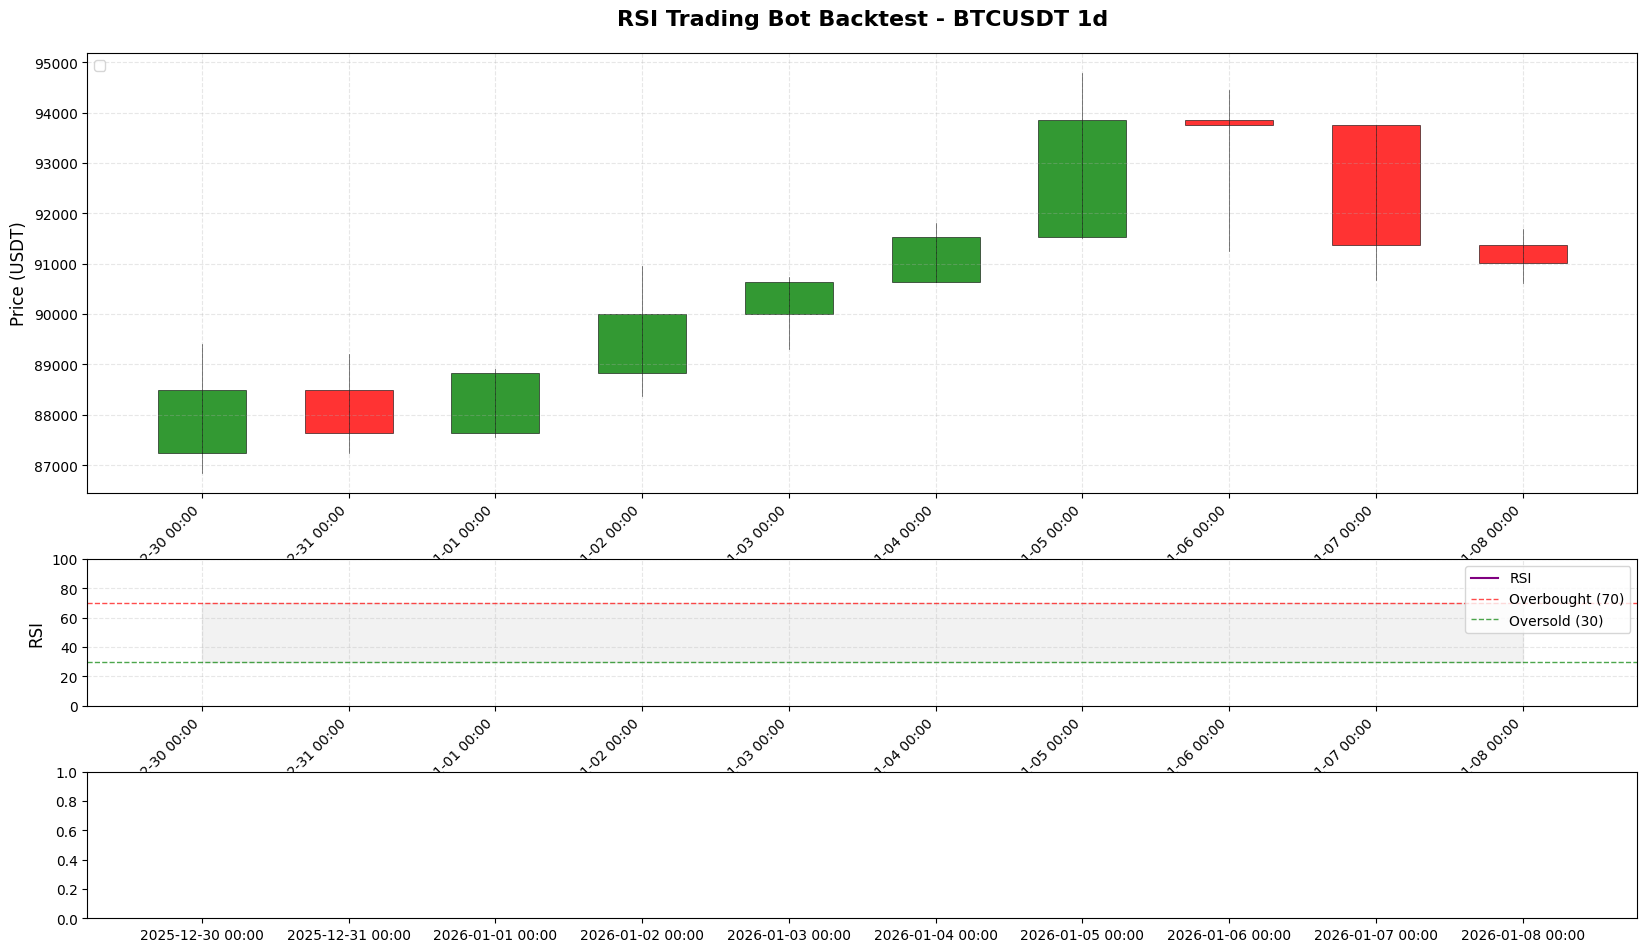

In [12]:
## RSI Trading Bot Backtest

# Import RSI bot modules
import rsi_bot_backtest
import rsi_bot_results
import rsi_bot_charts

# Configure backtest parameters
initial_capital = 10000  # $10,000 starting capital
buy_amount = 1000        # Buy $1,000 worth when RSI < 30 OR bullish divergence
sell_amount = 1000       # Sell $1,000 worth when RSI > 70 OR bearish divergence
rsi_period = 14          # RSI calculation period
fee_pct = 0.001          # 0.1% trading fee
use_divergence = True    # Enable divergence detection as confluence
divergence_lookback = 20 # Lookback period for divergence detection

# Run RSI bot backtest
print("Running RSI trading bot backtest with divergence confluence...")
results = rsi_bot_backtest.run_rsi_backtest(
    df, 
    initial_capital=initial_capital,
    buy_amount=buy_amount,
    sell_amount=sell_amount,
    rsi_period=rsi_period,
    fee_pct=fee_pct,
    use_divergence=use_divergence,
    divergence_lookback=divergence_lookback
)

# Create results object for easier access
results_obj = rsi_bot_results.create_results(results)

# Display summary
results_obj.print_summary()

# Visualize results
rsi_bot_charts.plot_backtest_overview(results, df, num_candles=1000, 
                                     symbol=config.SYMBOL, interval=config.INTERVAL)
rsi_bot_charts.plot_trade_analysis(results)

# Optional: Export results to CSV
# results_obj.export_all("rsi_bot_backtest")


In [ ]:
## Volume Breakout Trading Bot Backtest

# Import Volume bot modules
import volume_bot_backtest
import volume_bot_results
import volume_bot_charts

# Configure backtest parameters
initial_capital = 10000  # $10,000 starting capital
volume_threshold_btc = 300  # Volume threshold: 1 BTC
risk_pct = 0.25  # Risk: 1% from entry price
reward_pct = 0.5  # Reward: 2% from entry price (2:1 R:R)
max_holding_candles = 5  # Maximum holding period: 5 candles
rsi_period = 14  # RSI calculation period
fee_pct = 0.001  # 0.1% trading fee
stop_order_buffer_pct = 0.001  # 0.1% buffer above/below close for stop orders

# Run Volume bot backtest
print("Running Volume Breakout trading bot backtest...")
results = volume_bot_backtest.run_volume_backtest(
    df, 
    initial_capital=initial_capital,
    volume_threshold_btc=volume_threshold_btc,
    risk_pct=risk_pct,
    reward_pct=reward_pct,
    max_holding_candles=max_holding_candles,
    rsi_period=rsi_period,
    fee_pct=fee_pct,
    stop_order_buffer_pct=stop_order_buffer_pct
)

# Create results object for easier access
results_obj = volume_bot_results.create_results(results)

# Display summary
results_obj.print_summary()

# Visualize results
volume_bot_charts.plot_backtest_overview(results, df, num_candles=1000, 
                                        symbol=config.SYMBOL, interval=config.INTERVAL)
volume_bot_charts.plot_trade_analysis(results)

# Optional: Export results to CSV
results_obj.export_all("volume_bot_backtest")



In [ ]:
# Get and save signals
signals = data.get_btcusd_signals(save=True)

# View current signals as DataFrame
signals_df = pd.DataFrame(signals)
print("\nCurrent Signals DataFrame:")
print(signals_df)

In [ ]:
# Load and view historical signals
history_df = data.get_signals_history()

if len(history_df) > 0:
    print(f"Total historical signal records: {len(history_df)}")
    print(f"\nLatest signals:")
    print(history_df.tail(10))
    
    # Show signal counts by timeframe
    print(f"\nSignal counts by timeframe:")
    print(history_df.groupby('timeframe')['signal'].value_counts())
else:
    print("No historical signals found. Run cell 15 to capture signals.")

## Pattern Testing Framework

This section allows you to test each candlestick pattern in isolation. Select a pattern from the list below and run the corresponding cell to visualize its signals on the candlestick chart.

**Available Patterns:**
- **Trend-Following**: Marubozu, Three Candles, Three Methods, Tasuki, Hikkake, Quintuplets
- **Classic Contrarian**: Doji, Harami, Tweezers, Stick Sandwich, Hammer, Star, Piercing, Engulfing, Abandoned Baby, Spinning Top, Inside Up/Down, Tower, On Neck
- **Modern Trend-Following**: Double Trouble, Bottle, Slingshot, H Pattern
- **Modern Contrarian**: Doppelgänger, Blockade, Barrier, Mirror, Shrinking, Euphoria



In [ ]:
# Pattern Testing Configuration
# Select which pattern to test and configure parameters

PATTERN_NAME = "marubozu"  # Change this to test different patterns
NUM_CANDLES = 200  # Number of candles to analyze

# Pattern-specific parameters (adjust as needed)
PATTERN_PARAMS = {
    'marubozu': {},
    'three_candles': {'body': 0.0005},
    'three_methods': {},
    'tasuki': {},
    'hikkake': {},
    'quintuplets': {'body': 0.0003},
    'doji': {},
    'harami': {},
    'tweezers': {'body': 0.0003},
    'stick_sandwich': {},
    'hammer': {'body': 0.0003, 'wick': 0.0005},
    'star': {},
    'piercing': {},
    'engulfing': {},
    'abandoned_baby': {},
    'spinning_top': {'body': 0.0003, 'wick': 0.0003},
    'inside_up_down': {'body': 0.0003},
    'tower': {'body': 0.0003},
    'on_neck': {},
    'double_trouble': {'atr_period': 14},
    'bottle': {},
    'slingshot': {},
    'h_pattern': {},
    'doppelganger': {},
    'blockade': {},
    'barrier': {},
    'mirror': {},
    'shrinking': {},
    'euphoria': {}
}

# Get parameters for selected pattern
params = PATTERN_PARAMS.get(PATTERN_NAME.lower(), {})
print(f"Testing pattern: {PATTERN_NAME}")
print(f"Parameters: {params}")
print(f"Analyzing last {NUM_CANDLES} candles")



In [ ]:
# Test Pattern: Marubozu
# Single candle with no wicks, indicating strong momentum

charts.plot_candlestick_with_marubozu(df, num_candles=NUM_CANDLES, 
                                      symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Three Candles (Three White Soldiers / Three Black Crows)
# Three consecutive large candles of the same color

charts.plot_candlestick_with_three_candles(df, num_candles=NUM_CANDLES, body=0.0005,
                                           symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Three Methods
# Five-candle continuation pattern with consolidation

charts.plot_candlestick_with_three_methods(df, num_candles=NUM_CANDLES,
                                           symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Tasuki
# Three-candle gap continuation pattern

charts.plot_candlestick_with_tasuki(df, num_candles=NUM_CANDLES,
                                    symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Hikkake
# Five-candle false breakout pattern

charts.plot_candlestick_with_hikkake(df, num_candles=NUM_CANDLES,
                                     symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Quintuplets
# Five consecutive small candles in the same direction

charts.plot_candlestick_with_quintuplets(df, num_candles=NUM_CANDLES, body=0.0003,
                                         symbol=config.SYMBOL, interval=config.INTERVAL)



### Classic Contrarian Patterns



In [ ]:
# Test Pattern: Doji
# Single candle where open = close, signaling indecision

charts.plot_candlestick_with_doji(df, num_candles=NUM_CANDLES,
                                  symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Harami
# Two-candle reversal pattern with contained body

charts.plot_candlestick_with_harami(df, num_candles=NUM_CANDLES,
                                    symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Tweezers
# Two candles sharing the same high or low

charts.plot_candlestick_with_tweezers(df, num_candles=NUM_CANDLES, body=0.0003,
                                      symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Stick Sandwich
# Three-candle pattern with outer candles sandwiching middle

charts.plot_candlestick_with_stick_sandwich(df, num_candles=NUM_CANDLES,
                                            symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Hammer
# Single candle with long lower shadow

charts.plot_candlestick_with_hammer(df, num_candles=NUM_CANDLES, body=0.0003, wick=0.0005,
                                    symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Star (Morning Star / Evening Star)
# Three-candle reversal with gaps

charts.plot_candlestick_with_star(df, num_candles=NUM_CANDLES,
                                  symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Piercing (and Dark Cloud Cover)
# Two-candle bullish/bearish reversal

charts.plot_candlestick_with_piercing(df, num_candles=NUM_CANDLES,
                                      symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Engulfing
# Two-candle reversal with complete body engulfment

charts.plot_candlestick_with_engulfing(df, num_candles=NUM_CANDLES,
                                       symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Abandoned Baby
# Rare three-candle reversal with gaps and Doji

charts.plot_candlestick_with_abandoned_baby(df, num_candles=NUM_CANDLES,
                                            symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Spinning Top
# Three-candle indecision pattern

charts.plot_candlestick_with_spinning_top(df, num_candles=NUM_CANDLES, body=0.0003, wick=0.0003,
                                          symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Inside Up/Down
# Three-candle inside bar reversal

charts.plot_candlestick_with_inside_up_down(df, num_candles=NUM_CANDLES, body=0.0003,
                                            symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Tower
# Five-candle stabilization/reversal pattern

charts.plot_candlestick_with_tower(df, num_candles=NUM_CANDLES, body=0.0003,
                                   symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: On Neck
# Two-candle pattern with same close price

charts.plot_candlestick_with_on_neck(df, num_candles=NUM_CANDLES,
                                     symbol=config.SYMBOL, interval=config.INTERVAL)



### Modern Trend-Following Patterns



In [ ]:
# Test Pattern: Double Trouble
# Two-candle ATR-validated trend-following pattern

charts.plot_candlestick_with_double_trouble(df, num_candles=NUM_CANDLES, atr_period=14,
                                            symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Bottle
# Two-candle continuation with gap

charts.plot_candlestick_with_bottle(df, num_candles=NUM_CANDLES,
                                    symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Slingshot
# Four-candle breakout/pullback continuation

charts.plot_candlestick_with_slingshot(df, num_candles=NUM_CANDLES,
                                      symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: H Pattern
# Three-candle continuation with Doji

charts.plot_candlestick_with_h_pattern(df, num_candles=NUM_CANDLES,
                                       symbol=config.SYMBOL, interval=config.INTERVAL)



### Modern Contrarian Patterns



In [ ]:
# Test Pattern: Doppelgänger
# Three-candle reversal with twin candles

charts.plot_candlestick_with_doppelganger(df, num_candles=NUM_CANDLES,
                                         symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Blockade
# Four-candle stabilization pattern

charts.plot_candlestick_with_blockade(df, num_candles=NUM_CANDLES,
                                      symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Barrier
# Three-candle same support/resistance pattern

charts.plot_candlestick_with_barrier(df, num_candles=NUM_CANDLES,
                                     symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Mirror
# Four-candle U-turn reversal pattern

charts.plot_candlestick_with_mirror(df, num_candles=NUM_CANDLES,
                                    symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Shrinking
# Five-candle compression/breakout pattern

charts.plot_candlestick_with_shrinking(df, num_candles=NUM_CANDLES,
                                       symbol=config.SYMBOL, interval=config.INTERVAL)



In [ ]:
# Test Pattern: Euphoria (already implemented above)
# Three-candle exhaustion pattern

charts.plot_candlestick_with_euphoria(df, num_candles=NUM_CANDLES,
                                     symbol=config.SYMBOL, interval=config.INTERVAL)



## Pattern Testing Utilities

Use the functions below to list all available patterns and test patterns programmatically.



In [ ]:
# List all available patterns
all_patterns = patterns.list_all_patterns()
print("Available Patterns:")
print("=" * 80)
for p in all_patterns:
    print(f"{p['name'].upper():20} | {p['category']:25} | {p['description']}")



In [ ]:
# Test pattern programmatically using detect_pattern_by_name
# Example: Test Marubozu pattern
test_pattern = "marubozu"
df_with_pattern = patterns.detect_pattern_by_name(df.copy(), test_pattern)
print(f"\n{test_pattern.upper()} Pattern Detection Results:")
print(f"Bullish Signals: {df_with_pattern[f'{test_pattern}_bullish'].sum()}")
print(f"Bearish Signals: {df_with_pattern[f'{test_pattern}_bearish'].sum()}")



## LuxAlgo Support and Resistance Levels with Breaks

This section demonstrates the LuxAlgo Support and Resistance Levels indicator, which identifies pivot-based support/resistance levels and detects breaks with volume confirmation.

**Key Features:**
- Pivot-based level detection (left/right bars configurable)
- Volume oscillator for break confirmation
- Break signal detection (resistance/support breaks)
- Wick pattern recognition (bull/bear wicks)

**License:** CC BY-NC-SA 4.0 © LuxAlgo


In [ ]:
# Plot candlestick chart with Support and Resistance Levels
# Using default parameters: left_bars=15, right_bars=15, volume_threshold=20
from charts import plot_candlestick_with_sr_levels

plot_candlestick_with_sr_levels(df, num_candles=300, 
                                left_bars=15, right_bars=15, 
                                volume_threshold=20,
                                symbol=config.SYMBOL, interval=config.INTERVAL)


In [ ]:
# Analyze break signals programmatically
from calculations import detect_sr_breaks

# Detect breaks with default parameters
df_with_sr = detect_sr_breaks(df, left_bars=15, right_bars=15, volume_threshold=20)

# Get recent data
recent_data = df_with_sr.tail(200)

# Count break signals
resistance_breaks = recent_data[recent_data['resistance_break'] == 1]
support_breaks = recent_data[recent_data['support_break'] == 1]
bull_wick_breaks = recent_data[recent_data['bull_wick_break'] == 1]
bear_wick_breaks = recent_data[recent_data['bear_wick_break'] == 1]

print("Break Signal Analysis (Last 200 Candles):")
print("=" * 60)
print(f"Resistance Breaks (with volume): {len(resistance_breaks)}")
if len(resistance_breaks) > 0:
    print(f"  Latest: {resistance_breaks.index[-1]} at ${resistance_breaks['close'].iloc[-1]:,.2f}")

print(f"\nSupport Breaks (with volume): {len(support_breaks)}")
if len(support_breaks) > 0:
    print(f"  Latest: {support_breaks.index[-1]} at ${support_breaks['close'].iloc[-1]:,.2f}")

print(f"\nBull Wick Breaks: {len(bull_wick_breaks)}")
print(f"Bear Wick Breaks: {len(bear_wick_breaks)}")

# Current levels
current_resistance = recent_data['resistance_level'].iloc[-1]
current_support = recent_data['support_level'].iloc[-1]
current_price = recent_data['close'].iloc[-1]

print(f"\nCurrent Levels:")
if not pd.isna(current_resistance):
    distance_above = current_resistance - current_price
    print(f"  Resistance: ${current_resistance:,.2f} (${distance_above:,.2f} above current price)")
if not pd.isna(current_support):
    distance_below = current_price - current_support
    print(f"  Support: ${current_support:,.2f} (${distance_below:,.2f} below current price)")
print(f"  Current Price: ${current_price:,.2f}")


In [ ]:
# Volume Oscillator Analysis
# The volume oscillator shows volume momentum and participation

recent_data = df_with_sr.tail(200)

# Plot volume oscillator
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Volume bars
colors_vol = ['green' if close >= open else 'red' 
              for close, open in zip(recent_data['close'], recent_data['open'])]
ax1.bar(range(len(recent_data)), recent_data['volume'], color=colors_vol, alpha=0.6)
ax1.set_ylabel('Volume', fontsize=12)
ax1.set_title('Volume and Volume Oscillator Analysis', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Volume oscillator
ax2.plot(range(len(recent_data)), recent_data['volume_osc'], color='purple', linewidth=2, label='Volume Oscillator')
ax2.axhline(y=20, color='orange', linestyle='--', linewidth=1.5, label='Threshold (20)')
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.fill_between(range(len(recent_data)), 0, recent_data['volume_osc'], 
                 where=(recent_data['volume_osc'] > 20), 
                 color='green', alpha=0.2, label='Volume Confirmed')
ax2.set_ylabel('Volume Oscillator %', fontsize=12)
ax2.set_xlabel('Candle Index', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format x-axis
num_labels = 10
step = max(1, len(recent_data) // num_labels)
tick_positions = range(0, len(recent_data), step)
tick_labels = [recent_data.index[i].strftime('%Y-%m-%d %H:%M') for i in tick_positions]
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Statistics
print("Volume Oscillator Statistics:")
print("=" * 60)
print(f"Current Value: {recent_data['volume_osc'].iloc[-1]:.2f}%")
print(f"Average: {recent_data['volume_osc'].mean():.2f}%")
print(f"Max: {recent_data['volume_osc'].max():.2f}%")
print(f"Min: {recent_data['volume_osc'].min():.2f}%")
print(f"Above Threshold: {(recent_data['volume_osc'] > 20).sum()} candles ({((recent_data['volume_osc'] > 20).sum() / len(recent_data) * 100):.1f}%)")


In [ ]:
# Combined view: Support/Resistance with K's Envelopes
# This shows how S/R levels relate to K's Envelopes

from calculations import calculate_k_envelopes
from charts import plot_candlestick_with_sr_levels

# Calculate K's Envelopes
df_with_k = calculate_k_envelopes(df, lookback=800)

# Calculate S/R levels
df_combined = detect_sr_breaks(df_with_k, left_bars=15, right_bars=15, volume_threshold=20)

# Plot (S/R levels will be shown, you can manually add K's envelopes if needed)
plot_candlestick_with_sr_levels(df_combined, num_candles=200, 
                                left_bars=15, right_bars=15, 
                                volume_threshold=20,
                                symbol=config.SYMBOL, interval=config.INTERVAL)

# Compare levels
recent = df_combined.tail(1).iloc[0]
print("\nLevel Comparison:")
print("=" * 60)
if not pd.isna(recent['resistance_level']):
    print(f"S/R Resistance: ${recent['resistance_level']:,.2f}")
if not pd.isna(recent['k_envelope_upper']):
    print(f"K's Upper Envelope: ${recent['k_envelope_upper']:,.2f}")
if not pd.isna(recent['support_level']):
    print(f"S/R Support: ${recent['support_level']:,.2f}")
if not pd.isna(recent['k_envelope_lower']):
    print(f"K's Lower Envelope: ${recent['k_envelope_lower']:,.2f}")
print(f"Current Price: ${recent['close']:,.2f}")


In [ ]:
# Break Signal Statistics and Summary
# Analyze break signal performance and characteristics

recent_data = df_with_sr.tail(500)  # Analyze last 500 candles

# Get all breaks
all_breaks = recent_data[
    (recent_data['resistance_break'] == 1) | 
    (recent_data['support_break'] == 1) |
    (recent_data['bull_wick_break'] == 1) |
    (recent_data['bear_wick_break'] == 1)
]

print("Break Signal Statistics (Last 500 Candles):")
print("=" * 80)

if len(all_breaks) > 0:
    # Break types
    print(f"\nBreak Type Distribution:")
    print(f"  Resistance Breaks: {(recent_data['resistance_break'] == 1).sum()}")
    print(f"  Support Breaks: {(recent_data['support_break'] == 1).sum()}")
    print(f"  Bull Wick Breaks: {(recent_data['bull_wick_break'] == 1).sum()}")
    print(f"  Bear Wick Breaks: {(recent_data['bear_wick_break'] == 1).sum()}")
    
    # Volume analysis
    volume_confirmed = all_breaks[
        (all_breaks['resistance_break'] == 1) | 
        (all_breaks['support_break'] == 1)
    ]
    print(f"\nVolume Confirmation:")
    print(f"  Total Breaks: {len(all_breaks)}")
    print(f"  Volume Confirmed: {len(volume_confirmed)} ({len(volume_confirmed)/len(all_breaks)*100:.1f}%)")
    print(f"  Average Volume Osc: {all_breaks['volume_osc'].mean():.2f}%")
    print(f"  Max Volume Osc: {all_breaks['volume_osc'].max():.2f}%")
    
    # Price movement after breaks (simple analysis)
    print(f"\nBreak Signal Details:")
    for idx, row in all_breaks.tail(10).iterrows():
        break_type = []
        if row['resistance_break'] == 1:
            break_type.append("Resistance Break")
        if row['support_break'] == 1:
            break_type.append("Support Break")
        if row['bull_wick_break'] == 1:
            break_type.append("Bull Wick")
        if row['bear_wick_break'] == 1:
            break_type.append("Bear Wick")
        
        print(f"  {idx}: {', '.join(break_type)} at ${row['close']:,.2f} (Vol Osc: {row['volume_osc']:.2f}%)")
else:
    print("\nNo break signals detected in the last 500 candles.")
    print("Try adjusting parameters (left_bars, right_bars, volume_threshold) or analyze more candles.")

print("\n" + "=" * 80)
